<a href="https://colab.research.google.com/github/Rugeles13/cd-santiago-rugeles-2023/blob/main/Proyecto_K_Ripley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyproj

In [2]:
!pip install geopandas

In [3]:
!pip uninstall cython -y
!pip install cython
!pip uninstall cartopy -y
!pip install cartopy

Found existing installation: Cython 3.0.2
Uninstalling Cython-3.0.2:
  Successfully uninstalled Cython-3.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.3 MB/s eta 0:00:00


In [4]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-linux_x86_64.whl size=890037 sha256=9519369bff8ec6087a6550efaf8e2803a07194a92d96c8809b2defba2bfead3d
  Stored in directory: /root/.cache/pip/wheels/07/bd/06/4e979fa263bca266484ee65f5aab8e6b1c9b20f8caa6f2d7da
Successfully built shapely


In [6]:
import pandas as pd
import pyproj
import math
import matplotlib.pyplot as plt
import seaborn as sb
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
import time

In [7]:
ruta = 'https://raw.githubusercontent.com/fmoreno4/cd-files/main/eventos_dengue_2020.csv'
#ruta = 'https://raw.githubusercontent.com/rasief/cartografia/master/melb_data.csv'
df = pd.read_csv(ruta)
df

,ID,fec_not,semana,año,edad_,uni_med_,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,...,hipotension,hepatomegalia,hemorragia_mucosa,hipotermia,caida_plaquetas,acum_liquido,aum_hematocrito,conducta,latitud,longitud
0,1,17/01/2020,1,2020,25,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.076011,-73.102501
1,2,10/01/2020,1,2020,24,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.079495,-73.105400
2,3,12/01/2020,1,2020,58,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.090290,-73.091003
3,4,12/01/2020,1,2020,29,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.067435,-73.090958
4,5,10/01/2020,1,2020,56,1,F,170,68,276,...,2,2,2,2,1,2,2,2. Hospitalizacion piso,7.066905,-73.104980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1258,7/03/2020,9,2020,36,1,F,170,68,276,...,2,2,1,2,2,2,2,1. Ambulatorio,7.072610,-73.099487
1258,1259,13/03/2020,9,2020,42,1,M,170,68,276,...,2,2,2,2,1,2,1,2. Hospitalizacion piso,7.065252,-73.103607
1259,1260,8/03/2020,9,2020,2,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.091391,-73.103264
1260,1261,11/03/2020,9,2020,12,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.061083,-73.097000


In [8]:
#Creación de la proyección
P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)

In [17]:
#Se convertirán las coordenadas geográficas a UTM
df['x'], df['y'] = P(df['longitud'], df['latitud'])
df

,ID,fec_not,semana,año,edad_,uni_med_,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,...,hemorragia_mucosa,hipotermia,caida_plaquetas,acum_liquido,aum_hematocrito,conducta,latitud,longitud,x,y
0,1,17/01/2020,1,2020,25,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.076011,-73.102501,709584.027559,782579.281866
1,2,10/01/2020,1,2020,24,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.079495,-73.105400,709262.121378,782963.354103
2,3,12/01/2020,1,2020,58,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.090290,-73.091003,710847.924654,784163.825097
3,4,12/01/2020,1,2020,29,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.067435,-73.090958,710863.366771,781635.895608
4,5,10/01/2020,1,2020,56,1,F,170,68,276,...,2,2,1,2,2,2. Hospitalizacion piso,7.066905,-73.104980,709314.159319,781570.969374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1258,7/03/2020,9,2020,36,1,F,170,68,276,...,1,2,2,2,2,1. Ambulatorio,7.072610,-73.099487,709918.546763,782204.438977
1258,1259,13/03/2020,9,2020,42,1,M,170,68,276,...,2,2,1,2,1,2. Hospitalizacion piso,7.065252,-73.103607,709466.644754,781388.734012
1259,1260,8/03/2020,9,2020,2,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.091391,-73.103264,709492.782783,784279.996264
1260,1261,11/03/2020,9,2020,12,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.061083,-73.097000,710198.574916,780930.648555


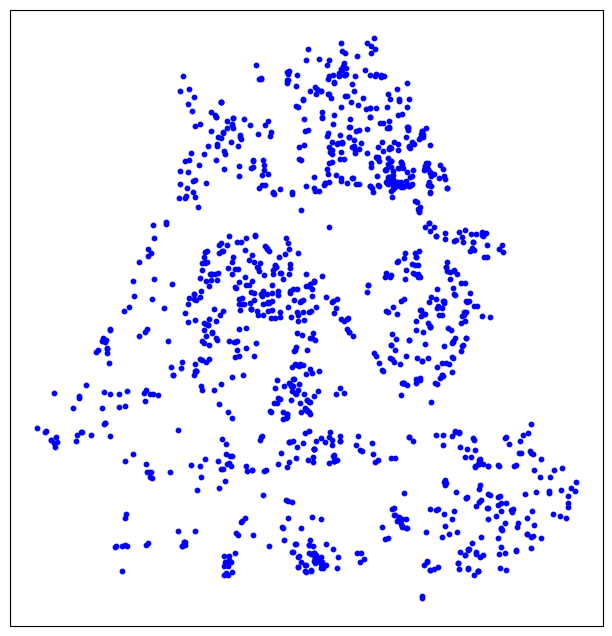

In [10]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)

ax.scatter(df['longitud'], df['latitud'], zorder=10, c='b', s=10)
plt.show()

In [11]:
#Se carga la cartografía de Floridablanca/Melbourne
url = 'https://raw.githubusercontent.com/fmoreno4/cd-files/main/'

file_list = ["68276_urbano.cpg", "68276_urbano.dbf", "68276_urbano.prj", "68276_urbano.shp", "68276_urbano.shx"]

for file in file_list:
    urllib.request.urlretrieve(url+file, file)

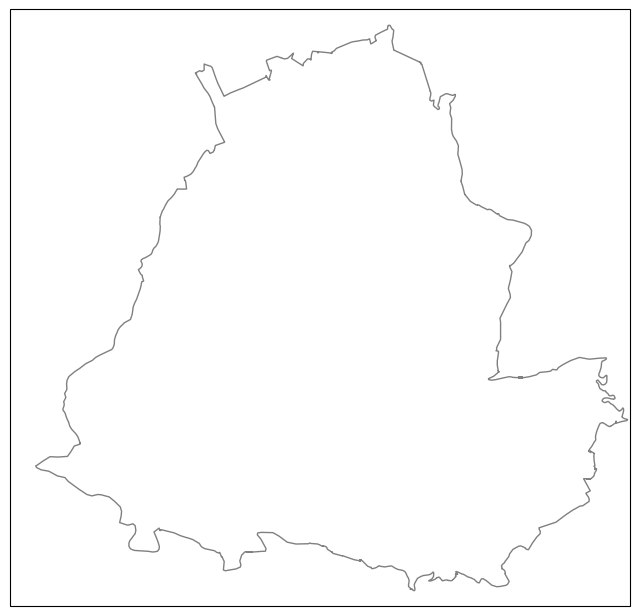

In [12]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)

# Puntos Floridablanca
lower_lon = -73.1215
upper_lon = -73.0732
lower_lat = 7.054
upper_lat = 7.1005

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_urbano.shp')

for poli in reader.geometries():
    ax.add_geometries([poli], ccrs.PlateCarree(), facecolor='white', edgecolor='gray')

plt.show()

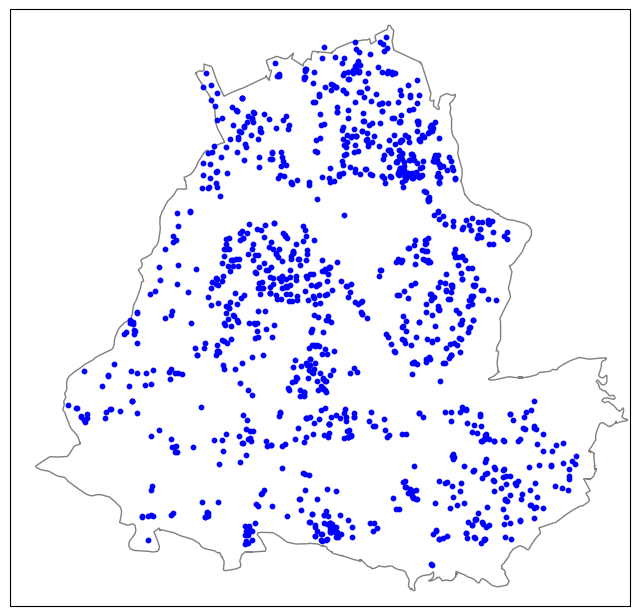

In [13]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)

# Puntos Floridablanca
lower_lon = -73.1215
upper_lon = -73.0732
lower_lat = 7.054
upper_lat = 7.1005

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_urbano.shp')

for poli in reader.geometries():
    ax.add_geometries([poli], ccrs.PlateCarree(), facecolor='white', edgecolor='gray')

ax.scatter(df['longitud'], df['latitud'], zorder=10, c='b', s=10)

plt.show()

In [14]:
import geopandas as gpd
import urllib.request

def calculate_polygon_area(df, shapefile_url):

    url = shapefile_url
    file_list = ["68276_urbano.cpg", "68276_urbano.dbf", "68276_urbano.prj", "68276_urbano.shp", "68276_urbano.shx"]
    for file in file_list:
        urllib.request.urlretrieve(url + file, file)

    gdf = gpd.read_file('68276_urbano.shp')
    gdf = gdf.to_crs('EPSG:32618')
    area = gdf.geometry.area.sum()

    return area

ruta = 'https://raw.githubusercontent.com/fmoreno4/cd-files/main/eventos_dengue_2020.csv'
df = pd.read_csv(ruta)
shapefile_url = 'https://raw.githubusercontent.com/fmoreno4/cd-files/main/'
polygon_area = calculate_polygon_area(df, shapefile_url)
print(f"Area del poligono: {polygon_area}")


Area del poligono: 14180920.862356503


In [15]:
import numpy as np

# Función para calcular la distancia euclidiana entre dos puntos
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Función para calcular el índice de Ripley con una distancia fija
def ripley_k_fixed_distance(data, fixed_distance):
    n = len(data)
    count = 0

    for i in range(n):
        for j in range(n):
            if j > i:
                dist = euclidean_distance(data[i], data[j])
                if dist <= fixed_distance:
                    count += 1

    ripley_value = (polygon_area/(n*n))*count #(count / n) / (np.pi * fixed_distance * fixed_distance)
    return ripley_value


In [19]:
# Crear una lista de coordenadas UTM
utm_coords = df[['x', 'y']].values
utm_coords

array([[709584.02755874, 782579.28186627],
       [709262.12137799, 782963.35410304],
       [710847.92465398, 784163.82509702],
       ...,
       [709492.78278312, 784279.99626355],
       [710198.57491572, 780930.64855507],
       [712027.27741723, 781097.16920956]])

In [21]:
# Distancias
distances = [20,40,60,80,100,120,140,160,180,200]

# Numero de grupos random a generar
num_random_groups = 9

ripley_original_list=[]
for distance in distances:
  # Calcular el índice de Ripley con la distancia fija para el conjunto original
  ripley_original = ripley_k_fixed_distance(utm_coords, distance)
  ripley_original_list.append(ripley_original)
ripley_original_list

[3632.836787029275,
 8610.179345728699,
 16160.781295240526,
 25376.43343880744,
 35420.158673535436,
 47155.64613751726,
 60956.86432353534,
 76351.90060974518,
 91809.26497808543,
 109127.5677986049]

In [23]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import pyproj

# Cargar el archivo shapefile
gdf = gpd.read_file('68276_urbano.shp')

# Definir el sistema de coordenadas original (latitud y longitud)
crs_original = {'init': 'epsg:4326'}

# Obtener el polígono como una instancia de Polygon
polygon = gdf.unary_union

# Número de puntos aleatorios deseados
num_points = 1262

utm_coords_random_list=[]

for _ in range(9):
  # Generar puntos aleatorios dentro del polígono
  random_points = []
  while len(random_points) < num_points:
      x = np.random.uniform(polygon.bounds[0], polygon.bounds[2])
      y = np.random.uniform(polygon.bounds[1], polygon.bounds[3])
      point = Point(x, y)
      if point.within(polygon):
          random_points.append(point)

  # Definir el sistema de coordenadas de destino (UTM, Zona 18 Norte)
  crs_destination = {'init': 'epsg:32618'}

  # Crear el transformador de coordenadas
  transformer = pyproj.Transformer.from_crs(crs_original, crs_destination, always_xy=True)

  # Convertir los puntos aleatorios a UTM
  utm_coords_random = [transformer.transform(point.x, point.y) for point in random_points]
  utm_coords_random_list.append(utm_coords_random)

utm_coords_random_list


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


[[(709666.7258935899, 781089.8549050809),
  (709283.4490331204, 780758.3005036681),
  (709586.6903012667, 783032.0477880185),
  (709756.4931799022, 783171.9743808565),
  (712246.8046598976, 781550.7737729313),
  (710465.4820411517, 782519.838863678),
  (711578.8160423749, 782480.7756926575),
  (711851.3281841276, 781172.5591113912),
  (710336.2679618162, 780880.8202606891),
  (711530.496148144, 781515.0418288338),
  (711219.4043073503, 784360.4984987024),
  (710275.9714778899, 783754.6705782483),
  (710222.5757897847, 783624.628944826),
  (710095.8824502925, 783552.5134140032),
  (710640.3634572283, 785077.5292857827),
  (712398.515124383, 782297.2927594915),
  (709928.9561937692, 784296.9996455017),
  (710705.3820150704, 784126.1252766846),
  (709342.7387648439, 783944.6690307168),
  (712327.0323254075, 781144.4511679247),
  (709730.8607732406, 780878.4881946698),
  (711604.143150278, 781480.1436887484),
  (710910.4264894708, 784060.2487294539),
  (710090.3499455188, 784419.878369034)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


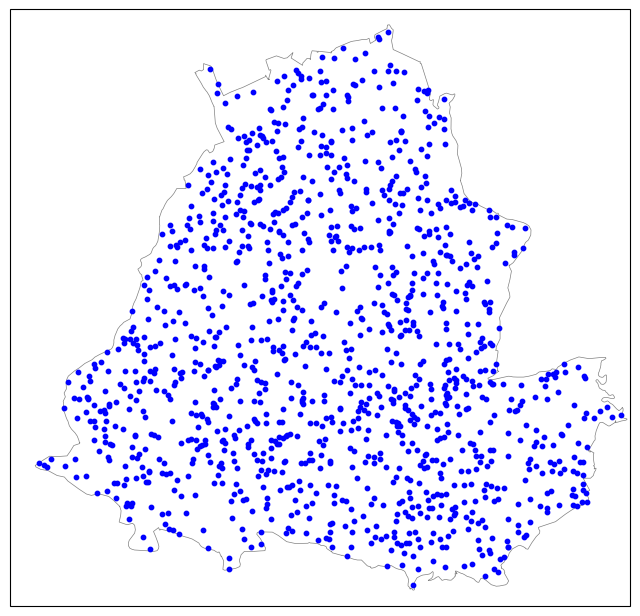

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapefile
import numpy as np

# Coordenadas UTM de la región de interés
lower_easting = 600000
upper_easting = 650000
lower_northing = 7500000
upper_northing = 7550000

# Crear la figura y el eje con la proyección PlateCarree
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

# Agregar características de fondo, como la costa
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Cargar el shapefile de los límites de la región
sf = shapefile.Reader('68276_urbano.shp')
shapes = sf.shapes()
for shape in shapes:
    vertices = np.array(shape.points)
    ax.plot(vertices[:, 0], vertices[:, 1], transform=ccrs.PlateCarree(), color='gray', linewidth=0.5)

# Generar puntos aleatorios en coordenadas UTM
num_points = len(utm_coords_random)
x_coords, y_coords = zip(*utm_coords_random)

# Graficar los puntos aleatorios
ax.scatter(x_coords, y_coords, transform=ccrs.UTM(18), zorder=10, c='b', s=10)

plt.show()


In [25]:
ripley_random_values_list = []

for distance in distances:
    ripley_random_values = []  # Crear una nueva lista para cada distancia
    for _ in range(num_random_groups):
        ripley_result = ripley_k_fixed_distance(utm_coords_random_list[_], distance)
        ripley_random_values.append(ripley_result)

    ripley_random_values_list.append(ripley_random_values)

ripley_random_values_list


[[516.4326805090636,
  614.3768095711274,
  578.7607626394679,
  552.0487274407232,
  543.1447157078084,
  667.8008799686168,
  676.7048917015317,
  712.3209386331912,
  614.3768095711274],
 [2466.4112500174247,
  2564.3553790794886,
  2502.0272969490843,
  2457.5072382845096,
  2172.5788628312334,
  2546.5473556136585,
  2608.8754377440628,
  2395.1791561541054,
  2341.755085756616],
 [5288.982969351445,
  5547.199309605977,
  5529.391286140147,
  5591.719368270551,
  5484.871227475573,
  5671.855473866785,
  5520.487274407232,
  5155.422793357721,
  5431.447157078083],
 [9838.932964870954,
  9874.549011802614,
  9874.549011802614,
  9740.98883580889,
  9527.292554218933,
  9723.18081234306,
  9705.37278887723,
  9456.060460355613,
  9776.60488274055],
 [15270.380121949036,
  15662.156638197292,
  15243.668086750293,
  15163.531981154058,
  14718.331394508314,
  15074.49186382491,
  15359.420239278186,
  14575.867206781675,
  15537.500473936483],
 [21850.44479257314,
  22081.949097628

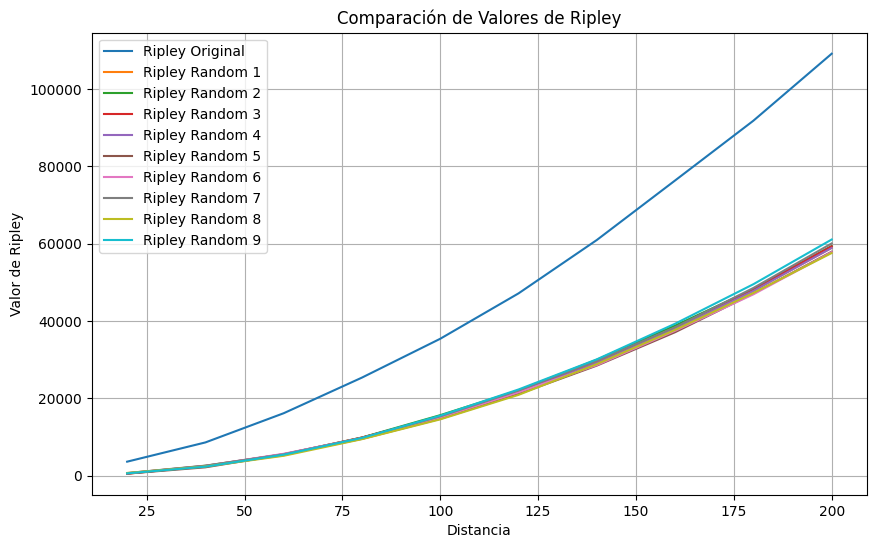

In [26]:
# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar los valores de Ripley original
plt.plot(distances, ripley_original_list, label='Ripley Original')

# Graficar los valores de Ripley con coordenadas UTM random
for i in range(len(ripley_random_values_list[0])):
    ripley_values = [ripley_random_values_list[j][i] for j in range(len(distances))]
    plt.plot(distances, ripley_values, label=f'Ripley Random {i+1}')

# Personalizar la gráfica
plt.xlabel('Distancia')
plt.ylabel('Valor de Ripley')
plt.title('Comparación de Valores de Ripley')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()